# Austin Traffic Predictions
## Charlie Henry
### August 5th 2022 

An experiment using a SARIMA time-series model to predict what future traffic volumes will look like.

#### SARIMA Model

SARIMA is an acronym for:

- Seasonal

- Autoregressive 

- Integrated 

- Moving Average

A SARIMA model takes in parameters for each of these sub-models and combines them to make predictions. It is typically written as:

$$
SARIMA =(p,d,q) \times (P,D,Q)_s
$$

$s$ is the period of the seasonal parameter, in this case we're using **7** to account for the day-of-week effects of traffic.

To pick parameters for SARIMA, we simply do a grid-search of $p,d,q,P,D,Q$ parameters to see which has the best performance in a statistic called $AIC$.

The most optimal found for grid search in space 0 to 2:

$$
SARIMA =(0, 1, 2) \times (0, 2, 2, 7)
$$

This produces a pretty good result for the day-ahead prediction:

![image](pic1.png)

***

#### Data source

This data is sourced from the Austin Open Data portal's [Camera Traffic Counts dataset.](https://data.austintexas.gov/Transportation-and-Mobility/Camera-Traffic-Counts/sh59-i6y9/data)

I've limited this analysis to the "OLTORF ST / 1ST ST" intersection as it has the most complete data.


***

#### Drawbacks

- Lack of uniqueness: SARIMA models are not unique, so many different parameters may actually provide similar or identical results.

- Holidays: this model heavily relies on day-of-week seasonality and the larger trend in the moving average, so it will not be able to change its prediction based on a 3-day weekend or Thanksgiving, for example

- Weather: this model doesn't consider the effects of weather apart from the seasonal effects it has on traffic volumes.

In [1]:
# Python default library
import warnings

# Third-party libraries
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm
from pylab import rcParams


Downloading data and transforming it into a datetime index, filling missing dates with zeroes.

In [2]:
DATA_URL = "https://data.austintexas.gov/resource/sh59-i6y9.csv?$select=sum(volume),date_trunc_ymd(read_date)%20as%20date&atd_device_id=7341&$group=date&$order=date%20DESC&$limit=10000"

In [3]:
df = pd.read_csv(DATA_URL,index_col=1)

In [4]:
df

,sum_volume
date,
2022-08-03T00:00:00.000,23364
2022-08-02T00:00:00.000,22347
2022-08-01T00:00:00.000,21051
2022-07-31T00:00:00.000,17029
2022-07-30T00:00:00.000,21590
...,...
2021-03-30T00:00:00.000,22549
2021-03-29T00:00:00.000,21590
2021-03-28T00:00:00.000,20283


In [5]:
df.index = pd.DatetimeIndex(df.index)
all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
df = df.reindex(all_days)
y = df[['sum_volume']]
y['sum_volume'] = y['sum_volume'].fillna(0)

Plotting seasonal components

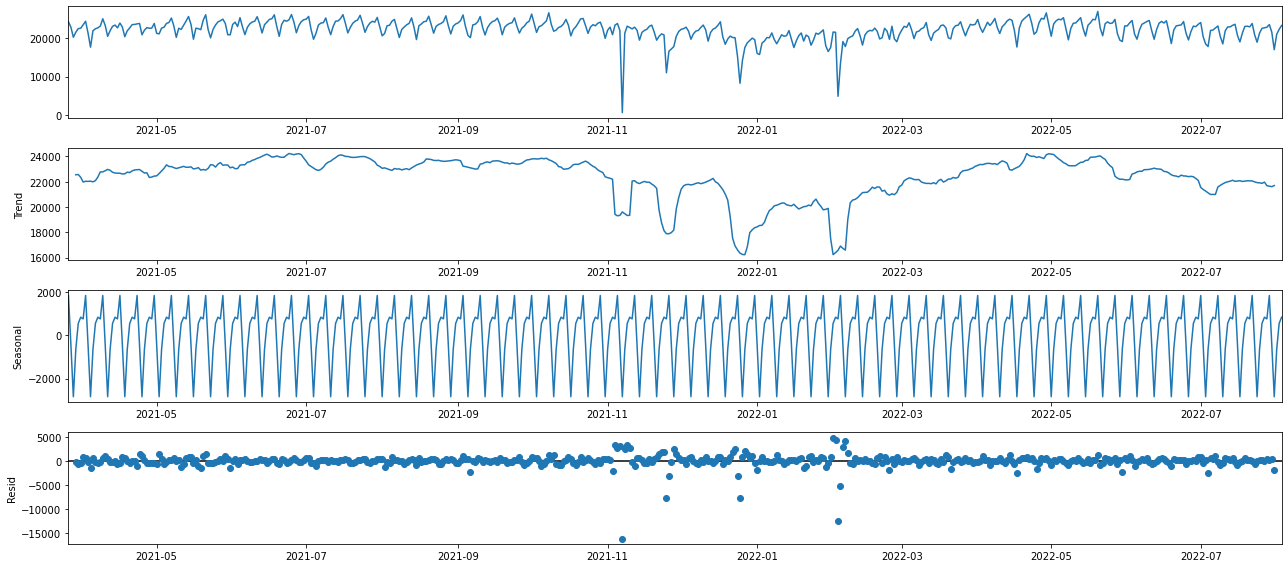

In [21]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [22]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [23]:
# Grid search of pdq x PDQ parameters
warnings.filterwarnings("ignore")

res = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=True,enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            
            res.append([param,param_seasonal,results.aic])
            
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)12 - AIC:11350.560607507789
ARIMA(0, 0, 0)x(0, 0, 1, 7)12 - AIC:11021.118616535008
ARIMA(0, 0, 0)x(0, 0, 2, 7)12 - AIC:10941.551697810373
ARIMA(0, 0, 0)x(0, 1, 0, 7)12 - AIC:8984.599910025701
ARIMA(0, 0, 0)x(0, 1, 1, 7)12 - AIC:8913.752180850683
ARIMA(0, 0, 0)x(0, 1, 2, 7)12 - AIC:8912.71347925596
ARIMA(0, 0, 0)x(0, 2, 0, 7)12 - AIC:9375.797405394445
ARIMA(0, 0, 0)x(0, 2, 1, 7)12 - AIC:9028.214736581025
ARIMA(0, 0, 0)x(0, 2, 2, 7)12 - AIC:9028.179927738545
ARIMA(0, 0, 0)x(1, 0, 0, 7)12 - AIC:9145.179488792728
ARIMA(0, 0, 0)x(1, 0, 1, 7)12 - AIC:8956.165792104326
ARIMA(0, 0, 0)x(1, 0, 2, 7)12 - AIC:8958.112378913225
ARIMA(0, 0, 0)x(1, 1, 0, 7)12 - AIC:8925.969924703722
ARIMA(0, 0, 0)x(1, 1, 1, 7)12 - AIC:8913.66705918459
ARIMA(0, 0, 0)x(1, 1, 2, 7)12 - AIC:8914.275019002793
ARIMA(0, 0, 0)x(1, 2, 0, 7)12 - AIC:9194.529143357751
ARIMA(0, 0, 0)x(1, 2, 1, 7)12 - AIC:9024.886372557263
ARIMA(0, 0, 0)x(1, 2, 2, 7)12 - AIC:9027.517539985689
ARIMA(0, 0, 0)x(2, 0, 0, 7)

ARIMA(0, 1, 2)x(2, 0, 1, 7)12 - AIC:8829.7098105793
ARIMA(0, 1, 2)x(2, 0, 2, 7)12 - AIC:8829.897133217086
ARIMA(0, 1, 2)x(2, 1, 0, 7)12 - AIC:8804.527548597016
ARIMA(0, 1, 2)x(2, 1, 1, 7)12 - AIC:8709.078625658587
ARIMA(0, 1, 2)x(2, 1, 2, 7)12 - AIC:8711.073839615605
ARIMA(0, 1, 2)x(2, 2, 0, 7)12 - AIC:8948.584490300083
ARIMA(0, 1, 2)x(2, 2, 1, 7)12 - AIC:8688.804876831997
ARIMA(0, 1, 2)x(2, 2, 2, 7)12 - AIC:8630.4047152844
ARIMA(0, 2, 0)x(0, 0, 0, 7)12 - AIC:9536.276375096004
ARIMA(0, 2, 0)x(0, 0, 1, 7)12 - AIC:9494.128379374048
ARIMA(0, 2, 0)x(0, 0, 2, 7)12 - AIC:9478.744575993729
ARIMA(0, 2, 0)x(0, 1, 0, 7)12 - AIC:9522.31153407698
ARIMA(0, 2, 0)x(0, 1, 1, 7)12 - AIC:9299.270341241809
ARIMA(0, 2, 0)x(0, 1, 2, 7)12 - AIC:9308.087280009046
ARIMA(0, 2, 0)x(0, 2, 0, 7)12 - AIC:9915.973689315571
ARIMA(0, 2, 0)x(0, 2, 1, 7)12 - AIC:9555.655167010693
ARIMA(0, 2, 0)x(0, 2, 2, 7)12 - AIC:9501.989550105918
ARIMA(0, 2, 0)x(1, 0, 0, 7)12 - AIC:9473.430063452954
ARIMA(0, 2, 0)x(1, 0, 1, 7)12 - A

ARIMA(1, 0, 2)x(1, 0, 1, 7)12 - AIC:8786.454187839026
ARIMA(1, 0, 2)x(1, 0, 2, 7)12 - AIC:8820.569607029556
ARIMA(1, 0, 2)x(1, 1, 0, 7)12 - AIC:8808.015396265535
ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:8676.111661431743
ARIMA(1, 0, 2)x(1, 1, 2, 7)12 - AIC:8737.732744142904
ARIMA(1, 0, 2)x(1, 2, 0, 7)12 - AIC:9107.717680826776
ARIMA(1, 0, 2)x(1, 2, 1, 7)12 - AIC:8768.223866031294
ARIMA(1, 0, 2)x(1, 2, 2, 7)12 - AIC:8961.999868656638
ARIMA(1, 0, 2)x(2, 0, 0, 7)12 - AIC:8935.986551788417
ARIMA(1, 0, 2)x(2, 0, 1, 7)12 - AIC:8780.440604473377
ARIMA(1, 0, 2)x(2, 0, 2, 7)12 - AIC:8844.983753069755
ARIMA(1, 0, 2)x(2, 1, 0, 7)12 - AIC:8793.990537481863
ARIMA(1, 0, 2)x(2, 1, 1, 7)12 - AIC:8682.461278191724
ARIMA(1, 0, 2)x(2, 1, 2, 7)12 - AIC:8739.071008999412
ARIMA(1, 0, 2)x(2, 2, 0, 7)12 - AIC:8960.285213298599
ARIMA(1, 0, 2)x(2, 2, 1, 7)12 - AIC:8725.055815890342
ARIMA(1, 0, 2)x(2, 2, 2, 7)12 - AIC:8984.816464789259
ARIMA(1, 1, 0)x(0, 0, 0, 7)12 - AIC:9127.434715653639
ARIMA(1, 1, 0)x(0, 0, 1, 7)1

ARIMA(1, 2, 2)x(0, 0, 1, 7)12 - AIC:9105.68185670712
ARIMA(1, 2, 2)x(0, 0, 2, 7)12 - AIC:9080.225018005347
ARIMA(1, 2, 2)x(0, 1, 0, 7)12 - AIC:8961.508718093872
ARIMA(1, 2, 2)x(0, 1, 1, 7)12 - AIC:8789.409578776696
ARIMA(1, 2, 2)x(0, 1, 2, 7)12 - AIC:8790.318778525208
ARIMA(1, 2, 2)x(0, 2, 0, 7)12 - AIC:9329.092355564457
ARIMA(1, 2, 2)x(0, 2, 1, 7)12 - AIC:9012.978353039096
ARIMA(1, 2, 2)x(0, 2, 2, 7)12 - AIC:8949.49598718118
ARIMA(1, 2, 2)x(1, 0, 0, 7)12 - AIC:9077.676213304752
ARIMA(1, 2, 2)x(1, 0, 1, 7)12 - AIC:8994.319931304812
ARIMA(1, 2, 2)x(1, 0, 2, 7)12 - AIC:8996.566401227697
ARIMA(1, 2, 2)x(1, 1, 0, 7)12 - AIC:8870.554689313798
ARIMA(1, 2, 2)x(1, 1, 1, 7)12 - AIC:8790.322472122305
ARIMA(1, 2, 2)x(1, 1, 2, 7)12 - AIC:8792.610586465933
ARIMA(1, 2, 2)x(1, 2, 0, 7)12 - AIC:9113.90197990289
ARIMA(1, 2, 2)x(1, 2, 1, 7)12 - AIC:8973.340004175225
ARIMA(1, 2, 2)x(1, 2, 2, 7)12 - AIC:8951.493997349116
ARIMA(1, 2, 2)x(2, 0, 0, 7)12 - AIC:9049.499176803098
ARIMA(1, 2, 2)x(2, 0, 1, 7)12 -

ARIMA(2, 1, 1)x(2, 0, 1, 7)12 - AIC:8862.686625731048
ARIMA(2, 1, 1)x(2, 0, 2, 7)12 - AIC:8864.572151205435
ARIMA(2, 1, 1)x(2, 1, 0, 7)12 - AIC:8800.951433432361
ARIMA(2, 1, 1)x(2, 1, 1, 7)12 - AIC:8709.487844889394
ARIMA(2, 1, 1)x(2, 1, 2, 7)12 - AIC:8763.795176565454
ARIMA(2, 1, 1)x(2, 2, 0, 7)12 - AIC:8929.233281396115
ARIMA(2, 1, 1)x(2, 2, 1, 7)12 - AIC:8691.631939927125
ARIMA(2, 1, 1)x(2, 2, 2, 7)12 - AIC:8965.558345991807
ARIMA(2, 1, 2)x(0, 0, 0, 7)12 - AIC:8980.07020723307
ARIMA(2, 1, 2)x(0, 0, 1, 7)12 - AIC:8934.6664256413
ARIMA(2, 1, 2)x(0, 0, 2, 7)12 - AIC:8914.061600362582
ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:8944.156405092477
ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:8818.2821979636
ARIMA(2, 1, 2)x(0, 1, 2, 7)12 - AIC:8770.651138812518
ARIMA(2, 1, 2)x(0, 2, 0, 7)12 - AIC:9274.990448475874
ARIMA(2, 1, 2)x(0, 2, 1, 7)12 - AIC:9025.277992096777
ARIMA(2, 1, 2)x(0, 2, 2, 7)12 - AIC:8971.55349737803
ARIMA(2, 1, 2)x(1, 0, 0, 7)12 - AIC:8913.151235152684
ARIMA(2, 1, 2)x(1, 0, 1, 7)12 - AI

In [24]:
# Sorting
res.sort(key=lambda row: (row[2]), reverse=False)

[[(0, 1, 2), (0, 2, 2, 7), 8611.366636552555],
 [(0, 1, 2), (2, 2, 2, 7), 8630.4047152844],
 [(1, 1, 1), (1, 2, 2, 7), 8631.75103795276],
 [(0, 1, 1), (2, 2, 2, 7), 8638.613947882353],
 [(2, 1, 0), (0, 2, 2, 7), 8647.26977471078],
 [(2, 1, 0), (1, 2, 2, 7), 8650.444413909605],
 [(1, 0, 2), (1, 1, 1, 7), 8676.111661431743],
 [(1, 0, 2), (0, 1, 1, 7), 8677.374098056342],
 [(2, 0, 1), (1, 1, 1, 7), 8681.075760397474],
 [(2, 0, 1), (0, 1, 1, 7), 8681.198548281132],
 [(1, 1, 0), (0, 2, 2, 7), 8681.410095918454],
 [(1, 0, 1), (0, 2, 2, 7), 8681.972022764017],
 [(1, 0, 2), (2, 1, 1, 7), 8682.461278191724],
 [(1, 1, 0), (1, 2, 2, 7), 8682.800288029017],
 [(0, 1, 2), (2, 2, 1, 7), 8688.804876831997],
 [(1, 1, 1), (2, 2, 1, 7), 8689.347521513228],
 [(1, 1, 0), (2, 2, 2, 7), 8689.710561477956],
 [(2, 1, 1), (2, 2, 1, 7), 8691.631939927125],
 [(1, 2, 1), (0, 2, 2, 7), 8696.781854590572],
 [(1, 1, 2), (2, 2, 1, 7), 8701.288749229514],
 [(0, 1, 1), (2, 2, 1, 7), 8705.771751892287],
 [(1, 1, 1), (1, 

In [25]:
# best result:
res[0]

[(0, 1, 2), (0, 2, 2, 7), 8611.366636552555]

In [6]:
# Fit model to the best parameters
mod = sm.tsa.statespace.SARIMAX(y,order=(0,1,2),seasonal_order=(0,2,2,7),enforce_stationarity=True,enforce_invertibility=False)
results = mod.fit(disp=0)

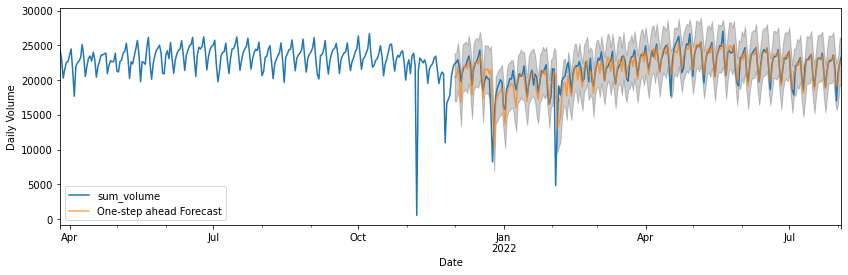

In [7]:
# One-step ahead chart
pred = results.get_prediction(start=pd.to_datetime('2021-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Volume')
plt.legend()
plt.show()

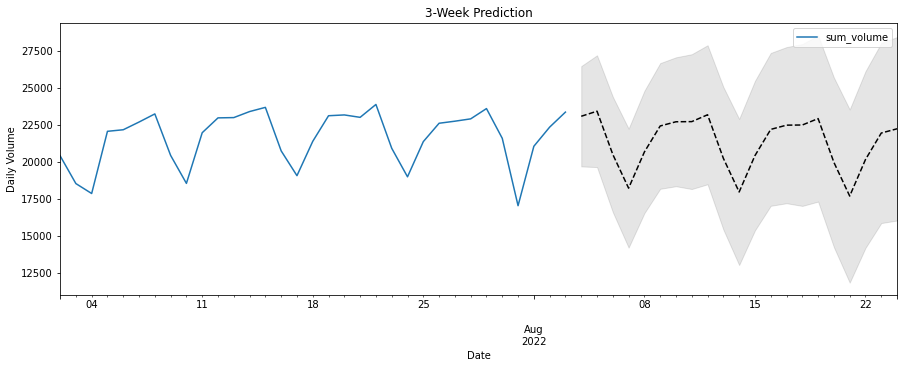

In [8]:
# Three-week prediction chart
fig, ax = plt.subplots(figsize=(15, 5))

y[y.index > '2022-07-01'].plot(ax=ax)

fcast = results.get_forecast(steps=21).summary_frame()
ax = fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
ax.set_ylabel('Daily Volume')
ax.set_xlabel('Date')
ax.set_title("3-Week Prediction")
plt.show(ax)